# Finetuning on CMP Dataset



## Introduction

I have finetuned the CMP dataset using the model and weights provided by the authors of "The devil is in the labels: Semantic segmentation from sentences". I have not tried to achieve a top accuracy - but hope it illustrates my approach and abilities. 

In [1]:
import sys
import os
import glob
import numpy as np
import torch
sys.path.insert(1, '/home/alex/facade/SSIW/Test_Minist/tools/')
import test as t
from utils.get_class_emb import create_embs_from_names
from utils.segformer import get_configured_segformer
from utils.labels_dict import UNI_UID2UNAME, ALL_LABEL2ID, UNAME2EM_NAME
from utils.transforms_utils import get_imagenet_mean_std, normalize_img, pad_to_crop_sz, resize_by_scaled_short_side
from utils.color_seg import color_seg

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import train
import plotting_utils as putils

/home/alex/miniconda3/envs/pytorch_cuda_dali/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset_dir = '/home/alex/facade/CMP_facade'
with open(os.path.join(dataset_dir,'label_names.txt')) as file:
    class_dict = {line.split()[0]:line.split()[1] for line in file}
class_labels = list(class_dict.values())
dataset = train.CMPDataset(os.path.join(dataset_dir, 'base'), resize=True)
weights = [file for file in glob.glob('model_weights*')]
weights_dict = {int(''.join(filter(str.isdigit,v))):v for v in weights}

## Data Preparation
As discussed in their paper data labels were converted to sentences to convey semantic meaning. I took these from wikipedia, and made them a little more explicit when I felt it was required. I use the same CLIP model to generate the embeddings.

In [3]:
sentences = {
        'background': 'the part of a picture, scene, or design that forms a setting for the main figures or objects, or appears furthest from the viewer.',
        'facade': 'the principal front of a building, that faces on to a street or open space.',
        'window': 'an opening in the wall or roof of a building or vehicle, fitted with glass in a frame to admit light or air and allow people to see out.',
        'door': 'a hinged, sliding, or revolving barrier at the entrance to a building, room, or vehicle, or in the framework of a cupboard.',
        'cornice': 'which is generally any horizontal decorative moulding that crowns a building or furniture element for example, the cornice over a door or window',
        'sill': 'a decorative (raised) panel or stripe under a window',
        'balcony': 'a platform projecting from the wall of a building, supported by columns or console brackets, and enclosed with a balustrade, usually above the ground floor.',
        'blind': 'a type of functional window covering used to obstruct light, made of hard or soft material; i.e. shutters, roller shades, wood blinds, standard vertical, and horizontal blinds',
        'deco': 'a piece of original art, paintings, reliefs, statues.',
        'molding': 'a horizontal decorative stripe across the facade, possibly with a repetitive texture pattern, used to cover transitions between surfaces or for decoration',
        'pillar': 'a vertical decorative stripe across the facade which is made of stone, or appearing to be so.',
        'shop': 'a building or part of a building where goods or services are sold or advertised.'}
# For consistency with paper include this preamble
def add_preamble(x): return f'This is a picture of a {x}, '
sentences = {k: add_preamble(k)+v for (k,v) in sentences.items()}

# Create embeddings
gt_embs_list = create_embs_from_names(class_labels, other_descriptions=sentences).float()
id_to_label = {i: v for i, v in enumerate(class_labels)}
id_to_label[255] = 'unlabel'

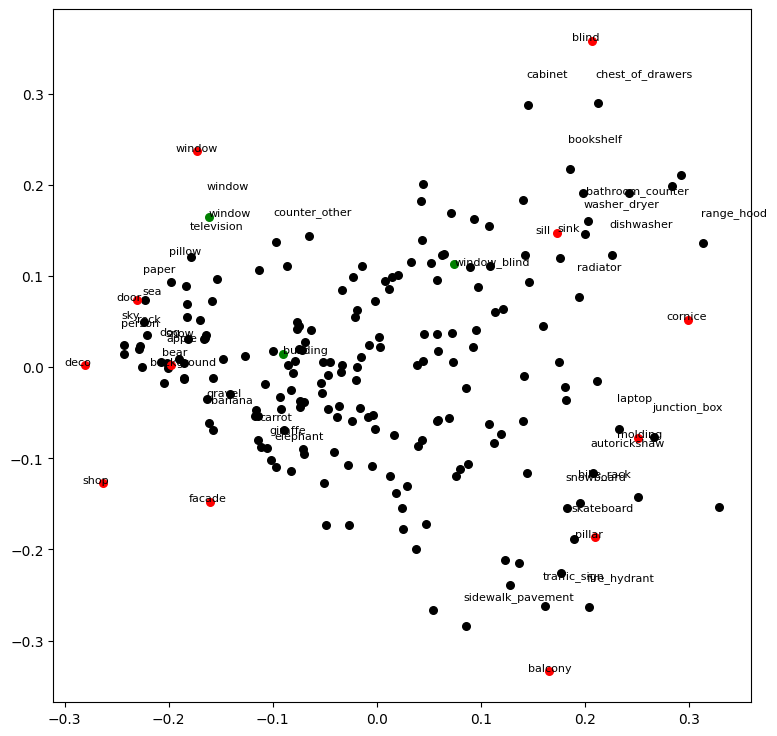

In [5]:
original_embs = np.load('models/universal_cat2vec.npy')
categories_of_interest = ['window', 'building', 'window_blind']
plt.figure(figsize=(9,9))
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(original_embs)

pca_embeddings2 = pca.fit_transform(gt_embs_list.cpu())
for i, (k, v) in enumerate(UNI_UID2UNAME.items()):
    if i == 194: break
    if v in categories_of_interest: 
        plt.text(pca_embeddings[i, 0], pca_embeddings[i, 1], v,fontsize=8)
        plt.scatter(pca_embeddings[i, 0], pca_embeddings[i, 1], s=30,c='green')
    else: plt.scatter(pca_embeddings[i, 0], pca_embeddings[i, 1], s=30,c='black')
    
for i, label in enumerate(class_labels):
    plt.scatter(pca_embeddings2[i, 0], pca_embeddings2[i, 1], s=30, c='red')
    plt.text(pca_embeddings2[i, 0] - 0.02, pca_embeddings2[i, 1], label, fontsize=8)
    distances = np.linalg.norm(pca_embeddings - pca_embeddings2[i], axis=1)
    for idx in np.argsort(distances)[:3]:
        # plt.scatter(pca_embeddings[idx, 0], pca_embeddings[idx, 1], s=30, c='black')
        plt.text(pca_embeddings[idx, 0]-0.002, pca_embeddings[idx, 1]+0.03, 
                    UNI_UID2UNAME[list(UNI_UID2UNAME.keys())[idx]], fontsize=8)
plt.show()

Its quite hard to see, but the embeddings look OK out of the box. Window is close with the already present 'window' class, but Window nor Blind in our dataset are near window_blind. This is not ideal, and future work would look to refine these embeddings to make more use of the features already learned. 

Likewise, from our sentences it should be obvious a facade is closer to building than elephant or giraffe are. 

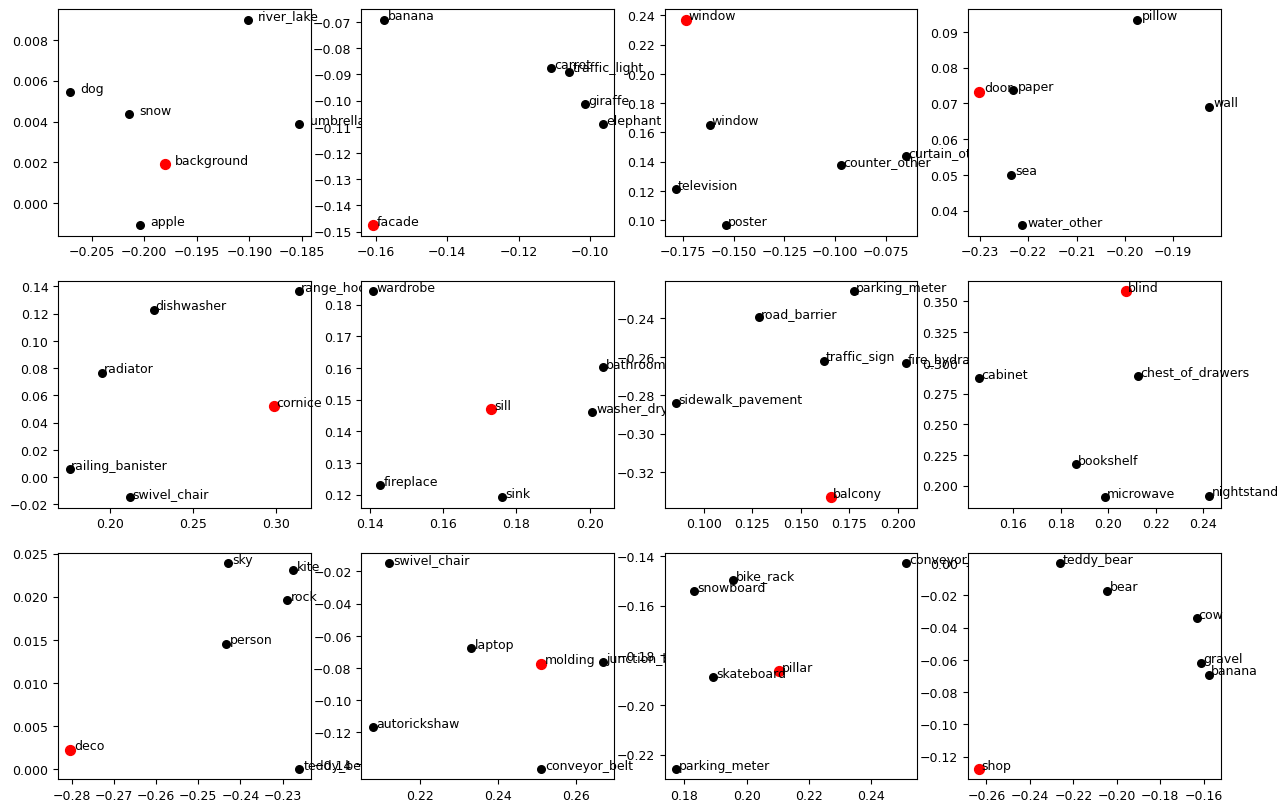

In [5]:
plt.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(3,4, figsize=(15, 10))
axs = axs.ravel()
for j, emb in enumerate(pca_embeddings2):
    axs[j].scatter(pca_embeddings2[j, 0], pca_embeddings2[j, 1], s=50, c='red')
    axs[j].text(pca_embeddings2[j, 0]+0.001, pca_embeddings2[j, 1], class_labels[j])
    distances = np.linalg.norm(pca_embeddings - pca_embeddings2[j], axis=1)
    sorted_indices = np.argsort(distances)
    for idx in sorted_indices[:5]:
        axs[j].scatter(pca_embeddings[idx, 0], pca_embeddings[idx, 1], s=30, c='black')
        axs[j].text(pca_embeddings[idx, 0]+0.001, pca_embeddings[idx, 1], 
                    UNI_UID2UNAME[list(UNI_UID2UNAME.keys())[idx]])

# Results

The network was trained for a few epochs on 90% of the base dataset. I made a few changes to the version on Github, and implemented the loss discussed in the paper with the temperature provided in the weights file. I found performance was better without the temperature parameter. I have provided the training script used. 

In [6]:
weight_path = '/home/alex/Downloads/model_weights_FT_b2_512_epoch16.pt'

In [7]:
num_model_classes = 512
model = get_configured_segformer(num_model_classes,criterion=None,load_imagenet_model=False)
model.train()
model = torch.nn.DataParallel(model)
ckpt_path = weight_path
checkpoint = torch.load(ckpt_path, map_location='cpu')
ckpt_filter = {k: v for k, v in checkpoint.items() if 'criterion.0.criterion.weight' not in k}
model.load_state_dict(ckpt_filter, strict=False)

single_args = putils.PredictionArgs(test_w=160, test_h=160)
test_split = 0.1
cm_total, mean_iou, class_iou_avg, img_metrics = putils.get_test_set_metrics(dataset, test_split, model, gt_embs_list, single_args)
class_str_iou = {class_dict[str(k+1)]:v for k,v in class_iou_avg.items()}

In [8]:
print(mean_iou)

0.2813670039445463


Preliminary results show OK performance, but some confusions did arise between a few classes, namely background:facade, door:window, blind:window. Overall many features were incorrectly predicted to be part of 'facade'. This is not surprising, as facade is likely the most dominant feature in the dataset, in terms of frequency and size. This could be addressed in the future by providing a weight in the loss function to reduce focus on this class.  

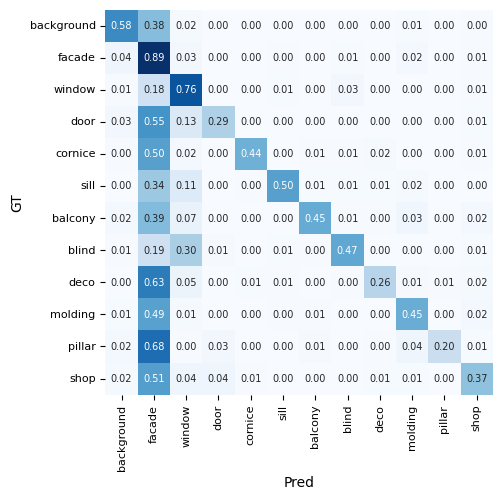

In [9]:
putils.plot_cm(cm_total, class_labels)

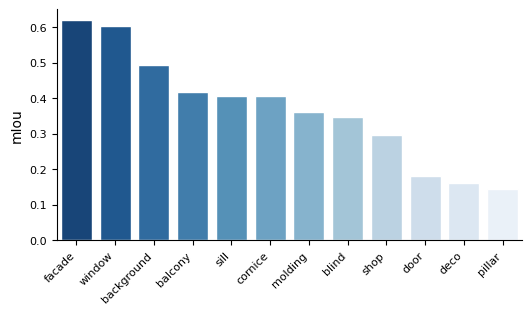

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 3))
colors = sns.color_palette('pastel')
sns.set_style('white')
df = pd.DataFrame.from_dict(class_str_iou, orient='index', columns=['Mean IoU'])
df = df.reset_index().rename(columns={'index': ''})
df_sorted = df.sort_values('Mean IoU', ascending=False)
sns.barplot(x='', y='Mean IoU', data=df_sorted, palette='Blues_r')
plt.ylabel('mIou')
ax.set_xlabel('')
ax.tick_params(labelsize=8)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()

The network is performing best on classes that have distinct and well defined shapes/boundaries (balcony, facade, window). These classes typically have easily distinguishable features.

Performance is lower for classes that have more complex, varied or nuanced shapes, such as blind, cornice, deco, and pillar. I observered these classes have more subtle variations in terms of colour, obfuscation and texture, which would make it harder for the network to distinguish them, and their boundaries.

The poorer performance on classes such as cornice, door, deco, and pillar could also be due to a lack of representative training data. I did not do an analysis on the distribution of labels throughout the dataset, which would be something to look at in further work. There is also the additional CMP dataset which could be utilised if needed. 

In [11]:
sorted_keys = sorted(img_metrics.keys(), key=lambda k: np.mean(img_metrics[k]['ious']))
best_5 = sorted_keys[:5]
worst_5 = sorted_keys[-5:]

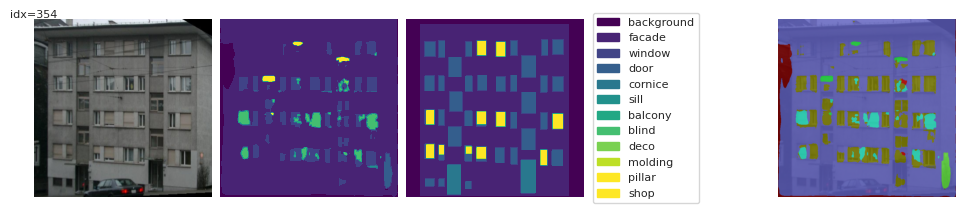

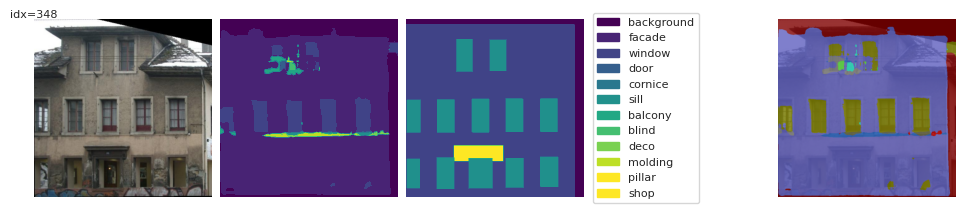

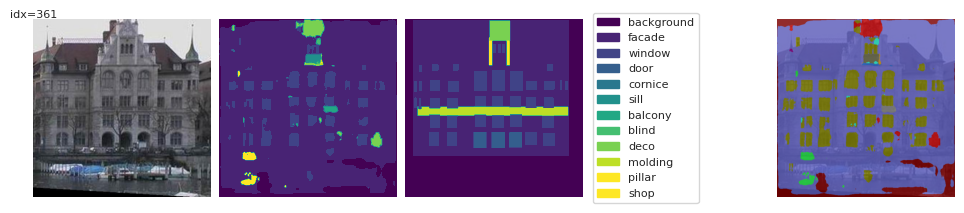

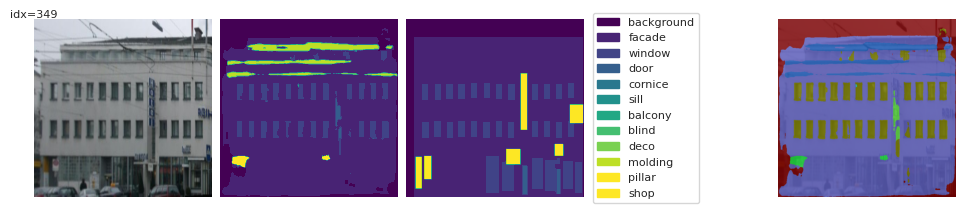

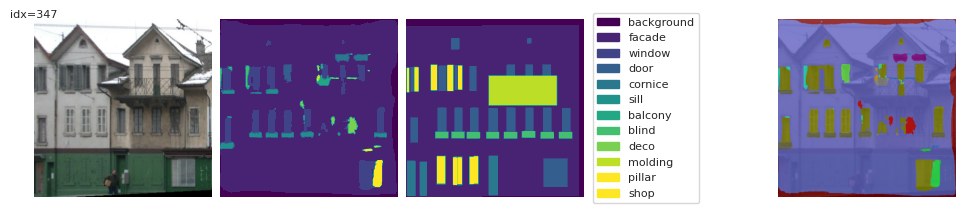

In [12]:
for index in best_5:
    x = dataset[index][0]
    y = dataset[index][1]
    putils.plot_predictions(index, x, y, class_labels, model, gt_embs_list, single_args)

The results shown above display the "best 5" images in terms of the mIoU out of the test set. Overall, given limited training and preprocessing the segmentations appear to be of decent quality and are able to accurately capture details on a relatively fine-grained level. However, there is a significant amount of noise present, as well as nonsensical masks and nonlinear contours.

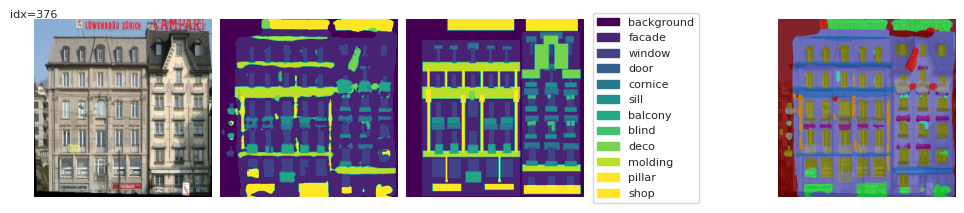

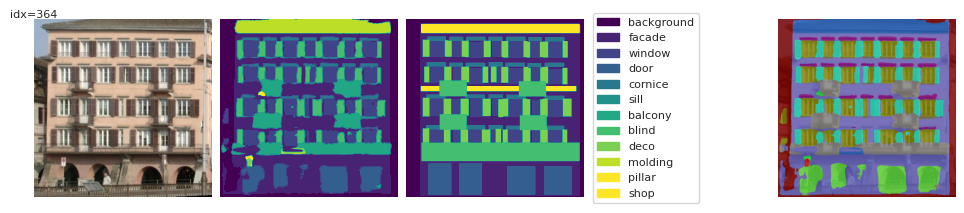

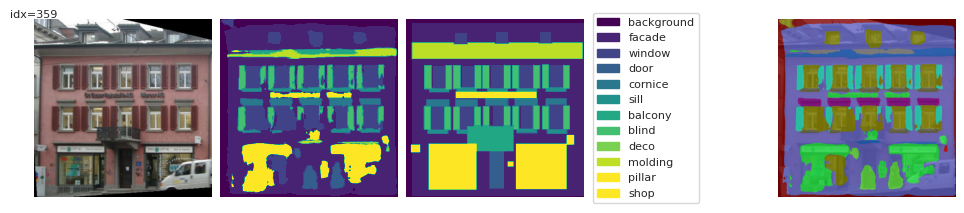

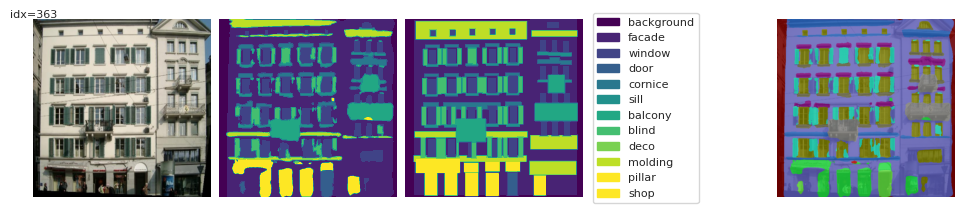

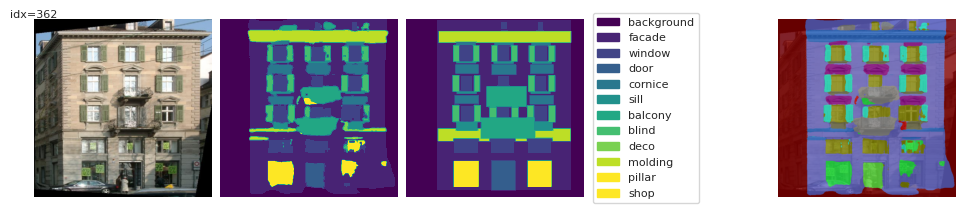

In [13]:
for index in worst_5: 
    x = dataset[index][0]
    y = dataset[index][1]
    putils.plot_predictions(index, x, y, class_labels, model, gt_embs_list, single_args)

The results displayed above provide a clear indication of the challenges facing the network when segmenting the test set. The masks are much more fuzzy, and the network struggles to capture finer details accurately. We can observe that obfuscation, such from as vans and trees, tend to confuse the network quite a lot.

These pictures highlight quite a few issues with the ground truth labels provided. In many cases, the network makes accurate guesses that are not validated by correct or consistent labels. For example:
- Inconsistency between shop & window labels (idx=352, bottom) (idx=368, behind van)
- Balconies are not labelled (idx=352)
- 'blind' is a very inconsistent label (idx=354, 363, 354)

Additionally, I would separate out the labels for shops and advertisements, as these two are visually and locationally distinct, with advertisements and logos often positioned at a higher point on the building.

## Next Steps / Recommendations
- Text Embeddings
    - Refine the used sentences to better fit into the embeddings the network was previously trained on
    - Refine sentences so that similiar objects are closer together in embedding space e.g (window, sill) 
    - Provide additional locational clues in the sentences and test affect on performance
    - Consult dataset more closely (my definition of door does not include archways, which are present in the data)

- Data:
    - Refine labels in the CMP dataset, seperating out classes where possible
    - Augment dataset with obfuscations, either real or synthetic 
    - More robust analysis on classes within dataset, e.g. how many types of pillars do we have? All of them? Ensure quantitatively we have sufficient data on a variety of architectural styles and these are well represented in training data. 
    - Buildings are easy to construct in synthetic enviroments, potential to easily augment the dataset there.
    
- Training:
    - Further training and HPO, at higher resolution if possible. 
    - Performing data augmentation methods & cropping at train time
    - Amend loss function to:
        - Consider depth channel as an input to optimise. Incorrect/nonsensical depth placement (prediction) should penalise the network. 
        - Penalize segmentation results that do not match the expected shapes & sizes.
        - Introduce a rectangular loss component. Penalise the network for boundaries/segments that are not bounded by straight lines.
    - Explore the use of transfer learning or model fusion techniques to combine the outputs of different models such as semantic segmentation + object detection models. For preliminary results the above look promising, and as part of a larger pipeline should be able to be cleaned upi.
        
- Evaluation:
    - A few methods have been employed here to get a sense of performance, but instance segmentation, AP and the depth quality measure used in the paper should also be investigated. 

Thank you for reading!